In [ ]:
! pip install torchtext==0.6.0
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 43.9 MB/s eta 0:00:00


In [ ]:
from torchtext import data
import torch

In [ ]:
TEXT = data.Field(include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext.datasets import IMDB
import os

train_path = "imdb_train.pt"
test_path  = "imdb_test.pt"

if os.path.exists(train_path) and os.path.exists(test_path):
    train_dump = torch.load(train_path, weights_only=False)
    test_dump  = torch.load(test_path,  weights_only=False)
else:
    train_data, test_data = IMDB.splits(TEXT, LABEL)
    train_dump = [(ex.text, ex.label) for ex in train_data.examples]
    test_dump  = [(ex.text, ex.label) for ex in test_data.examples]

    torch.save(train_dump, train_path)
    torch.save(test_dump,  test_path)
    print("saved dumps")

X_train = [t for (t, y) in train_dump]
y_train = [y for (t, y) in train_dump]
X_test  = [t for (t, y) in test_dump]
y_test  = [y for (t, y) in test_dump]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:12<00:00, 6.95MB/s]


saved dumps


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Check class distribution in validation set
y_val_bin = [1 if y == 'pos' else 0 for y in y_val]
print(f"\nValidation set class distribution:")
print(pd.Series(y_val_bin).value_counts())

Training set size: 20000
Validation set size: 5000
Test set size: 25000

Validation set class distribution:
1    2500
0    2500
Name: count, dtype: int64


In [ ]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd

y_train_bin = [1 if y == 'pos' else 0 for y in y_train]
pd.Series(y_train_bin).value_counts()

y_val_bin = [1 if y == 'pos' else 0 for y in y_val]
pd.Series(y_val_bin).value_counts()

y_test_bin = [1 if y == 'pos' else 0 for y in y_test]
pd.Series(y_test_bin).value_counts()

,count
1,12500
0,12500


In [ ]:
import re

TOKEN_PATTERN = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

def tokenize(text: str):
    text = text.lower()
    tokens = TOKEN_PATTERN.findall(text)
    return [t for t in tokens if t not in stopwords]


In [ ]:
def normalize_tokens(tokens):
    norm = []
    for token in tokens:
        token = token.lower()
        if token not in stopwords and token.isalpha():
            norm.append(token)
    return norm


In [ ]:
X_train_norm = [normalize_tokens(doc) for doc in X_train]
X_val_norm   = [normalize_tokens(doc) for doc in X_val]
X_test_norm  = [normalize_tokens(doc) for doc in X_test]

In [ ]:
from collections import Counter

train_tokens = []
counter = Counter()

for toks in X_train_norm:
    train_tokens.append(toks)
    counter.update(toks)

PAD, UNK = "<pad>", "<unk>"
min_freq = 2

itos = [PAD, UNK] + [w for w, c in counter.items() if c >= min_freq]
stoi = {w: i for i, w in enumerate(itos)}

pad_idx = stoi[PAD]
unk_idx = stoi[UNK]



In [ ]:
from gensim.models import Word2Vec

EMBED_DIM = 200

w2v = Word2Vec(
    sentences=train_tokens,
    vector_size=EMBED_DIM,
    window=5,
    min_count=min_freq,
    sg=1,          # skip-gram
    negative=10,
    workers=4,
    epochs=5
)

In [ ]:
import numpy as np
import torch

vocab_size = len(itos)

embedding_matrix = np.random.normal(
    loc=0.0,
    scale=0.1,
    size=(vocab_size, EMBED_DIM)
).astype(np.float32)

embedding_matrix[pad_idx] = 0.0

for word, idx in stoi.items():
    if word in (PAD, UNK):
        continue
    if word in w2v.wv:
        embedding_matrix[idx] = w2v.wv[word]

embedding_weight = torch.tensor(embedding_matrix)


In [ ]:
def encode(tokens):
    return [stoi.get(t, unk_idx) for t in tokens]

X_train_ids = [encode(toks) for toks in X_train_norm]
X_val_ids   = [encode(toks) for toks in X_val_norm]
X_test_ids  = [encode(toks) for toks in X_test_norm]


In [ ]:
import pandas as pd

y_train_bin = [1 if y == 'pos' else 0 for y in y_train]
y_val_bin = [1 if y == 'pos' else 0 for y in y_val]
y_test_bin = [1 if y == 'pos' else 0 for y in y_test]

def filter_empty_sequences(X_ids, y_bins):
    filtered_X_ids = []
    filtered_y_bins = []
    for x_id, y_bin in zip(X_ids, y_bins):
        if len(x_id) > 0:
            filtered_X_ids.append(x_id)
            filtered_y_bins.append(y_bin)
    return filtered_X_ids, filtered_y_bins

X_train_ids, y_train_bin = filter_empty_sequences(X_train_ids, y_train_bin)
X_val_ids, y_val_bin = filter_empty_sequences(X_val_ids, y_val_bin)
X_test_ids, y_test_bin = filter_empty_sequences(X_test_ids, y_test_bin)

print(f"Train set size after filtering: {len(X_train_ids)}")
print(f"Validation set size after filtering: {len(X_val_ids)}")
print(f"Test set size after filtering: {len(X_test_ids)}")

Train set size after filtering: 20000
Validation set size after filtering: 5000
Test set size after filtering: 24999


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
def collate_fn(batch):
    texts, labels = zip(*batch)

    lengths = torch.tensor([len(t) for t in texts])
    max_len = max(lengths)

    padded = torch.full(
        (len(texts), max_len),
        pad_idx,
        dtype=torch.long
    )

    for i, t in enumerate(texts):
        padded[i, :len(t)] = torch.tensor(t)

    return padded, lengths, torch.tensor(labels)


In [ ]:
train_ds = TextDataset(X_train_ids, y_train_bin)
val_ds   = TextDataset(X_val_ids, y_val_bin)

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)


In [ ]:
import torch.nn as nn

class StackedBiRNN_MaxPool(nn.Module):
    def __init__(
        self,
        embedding_weight: torch.Tensor,
        pad_idx: int,
        rnn_type: str = "lstm",
        hidden_dim: int = 256,
        num_layers: int = 2,
        dropout: float = 0.3,
        num_classes: int = 2,
        freeze_embed: bool = False,
    ):
        super().__init__()
        V, D = embedding_weight.shape

        self.emb = nn.Embedding.from_pretrained(
            embedding_weight, freeze=freeze_embed, padding_idx=pad_idx
        )

        RNN = nn.LSTM if rnn_type.lower() == "lstm" else nn.GRU
        self.rnn = RNN(
            input_size=D,
            hidden_size = hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1.0 else 0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * hidden_dim, num_classes)


    def forward(self, x, lengths):
        emb = self.emb(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out,_ = self.rnn(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(
            packed_out, batch_first=True
        )

        B, T, H2 = out.shape
        mask = torch.arange(T, device=lengths.device).unsqueeze(0) >= lengths.unsqueeze(1)  # (B,T)
        out = out.masked_fill(mask.unsqueeze(-1), float("-inf"))

        pooled = out.max(dim=1).values
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits

In [ ]:
import torch.nn.functional as F

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, lengths, y in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x, lengths)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, lengths, y in loader:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)

        logits = model(x, lengths)
        loss = F.cross_entropy(logits, y)

        total_loss += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


def fit_best_epoch(model, train_loader, dev_loader, device,
                   lr=2e-3, max_epochs=20, patience=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {
        "train_loss_epoch": [],
        "dev_loss_epoch": [],
        "train_loss_step": [],
        "global_step": []
    }
    best_dev_acc = -1.0
    best_state = None
    bad = 0

    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device)
        dv_loss, dv_acc = evaluate(model, dev_loader, device)
        history["train_loss_epoch"].append(tr_loss)
        history["dev_loss_epoch"].append(dv_loss)
        history["train_loss_step"].append(tr_loss)
        history["global_step"].append(epoch)
        print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} "
              f"| dev loss {dv_loss:.4f} acc {dv_acc:.4f}")

        if dv_acc > best_dev_acc:
            best_dev_acc = dv_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"Early stopping. Best dev acc = {best_dev_acc:.4f}")
                break

    model.load_state_dict(best_state)
    return best_dev_acc, history


Epoch 01 | train loss 0.4043 acc 0.8210 | dev loss 0.3261 acc 0.8598
Epoch 02 | train loss 0.1960 acc 0.9277 | dev loss 0.3159 acc 0.8704
Epoch 03 | train loss 0.0761 acc 0.9744 | dev loss 0.4289 acc 0.8576
Epoch 04 | train loss 0.0288 acc 0.9900 | dev loss 0.5467 acc 0.8500
Epoch 05 | train loss 0.0152 acc 0.9948 | dev loss 0.7831 acc 0.8474
Early stopping. Best dev acc = 0.8704
Epoch 01 | train loss 0.3673 acc 0.8345 | dev loss 0.2914 acc 0.8792
Epoch 02 | train loss 0.1625 acc 0.9392 | dev loss 0.3721 acc 0.8594
Epoch 03 | train loss 0.0478 acc 0.9848 | dev loss 0.4936 acc 0.8584
Epoch 04 | train loss 0.0228 acc 0.9922 | dev loss 0.6280 acc 0.8514
Early stopping. Best dev acc = 0.8792
Epoch 01 | train loss 0.3728 acc 0.8316 | dev loss 0.3268 acc 0.8650
Epoch 02 | train loss 0.1774 acc 0.9325 | dev loss 0.3308 acc 0.8648
Epoch 03 | train loss 0.0653 acc 0.9774 | dev loss 0.4621 acc 0.8512
Epoch 04 | train loss 0.0221 acc 0.9923 | dev loss 0.6058 acc 0.8532
Early stopping. Best dev ac

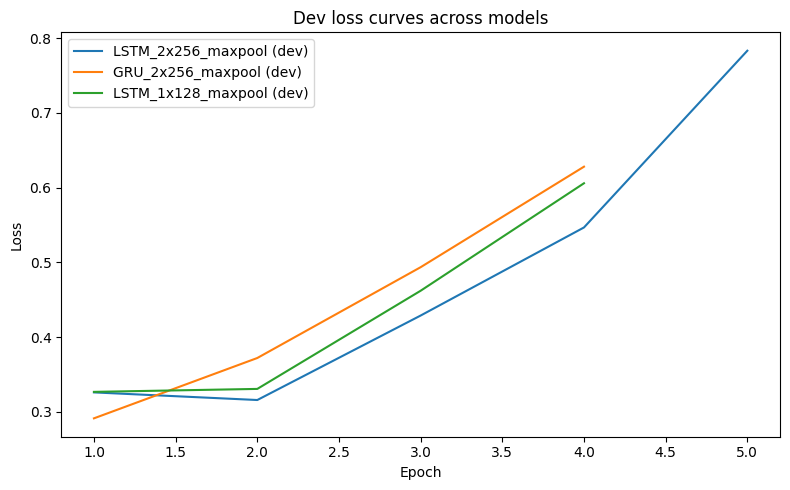

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

configs = [
    dict(name="LSTM_2x256_maxpool", rnn_type="lstm", hidden_dim=256, num_layers=2, dropout=0.3),
    dict(name="GRU_2x256_maxpool",  rnn_type="gru",  hidden_dim=256, num_layers=2, dropout=0.3),
    dict(name="LSTM_1x128_maxpool", rnn_type="lstm", hidden_dim=128, num_layers=1, dropout=0.2),
]

results = []

for cfg in configs:
    model = StackedBiRNN_MaxPool(
        embedding_weight=embedding_weight,
        pad_idx=pad_idx,
        rnn_type=cfg["rnn_type"],
        hidden_dim=cfg["hidden_dim"],
        num_layers=cfg["num_layers"],
        dropout=cfg["dropout"],
        freeze_embed=False
    ).to(device)

    best_dev, history = fit_best_epoch(
        model,
        train_loader,
        val_loader,
        device,
        lr=2e-3,
        max_epochs=20,
        patience=3
    )

    results.append({
        "name": cfg["name"],
        "best_dev": best_dev,
        "history": history,
        "model": model
    })

results_sorted = sorted(results, key=lambda x: x["best_dev"], reverse=True)
for r in results_sorted:
    print(r["name"], "best_dev:", r["best_dev"])

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for r in results:
    hist = r["history"]
    epochs = range(1, len(hist["train_loss_epoch"]) + 1)
    plt.plot(epochs, hist["dev_loss_epoch"], label=f'{r["name"]} (dev)')
    plt.plot(epochs, hist["dev_loss_epoch"], label=f'{r["name"]} (dev)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Dev loss curves across models")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
test_ds   = TextDataset(X_test_ids, y_test_bin)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    ys, ps = [], []
    for x, lengths, y in loader:
        x, lengths = x.to(device), lengths.to(device)
        logits = model(x, lengths)
        pred = logits.argmax(1).cpu().numpy()
        ps.append(pred)
        ys.append(y.numpy())
    return np.concatenate(ys), np.concatenate(ps)

y_true, y_pred = predict_all(model, test_loader, device)
print(classification_report(y_true, y_pred, target_names=["neg","pos"]))


              precision    recall  f1-score   support

         neg       0.84      0.85      0.85     12499
         pos       0.85      0.84      0.85     12500

    accuracy                           0.85     24999
   macro avg       0.85      0.85      0.85     24999
weighted avg       0.85      0.85      0.85     24999

